In [1]:
import numpy as np
from scipy.integrate import fixed_quad
import plotly.graph_objects as go
import pandas as pd
from iminuit import Minuit
from iminuit.cost import LeastSquares
import time
import os 
import matplotlib.pyplot as plt

In [2]:
# Load experimental data
atlas_data = pd.read_csv('data/ens_atlas_difc0_2.dat', delim_whitespace=True, header=None)
totem_data = pd.read_csv('data/ens_totem_difc0_2.dat', delim_whitespace=True, header=None)

# Function to process data for each experiment
def process_data(data, energy_blocks):
    x_values = []
    y_values = []
    y_errors = []
    
    for start, end in energy_blocks:
        block = data.iloc[start:end] if end is not None else data.iloc[start:]
        x_values.append(block[0].values)
        y_values.append(block[1].values)
        y_errors.append(block[2].values)
    
    return x_values, y_values, y_errors

# Energy ranges for each experiment (7TeV, 8TeV, 13TeV)
atlas_blocks = [(0, 29), (29, 58), (58, None)]
totem_blocks = [(0, 65), (65, 118), (118, None)]

# Process data
x_atlas, y_atlas, yerr_atlas = process_data(atlas_data, atlas_blocks)
x_totem, y_totem, yerr_totem = process_data(totem_data, totem_blocks)

# Extract values by energy (index 0=7TeV, 1=8TeV, 2=13TeV)

# ATLAS results
x_7_atlas, y_7_atlas, yerr_7_atlas = x_atlas[0], y_atlas[0], yerr_atlas[0]
x_8_atlas, y_8_atlas, yerr_8_atlas = x_atlas[1], y_atlas[1], yerr_atlas[1]
x_13_atlas, y_13_atlas, yerr_13_atlas = x_atlas[2], y_atlas[2], yerr_atlas[2]

# TOTEM results
x_7_totem, y_7_totem, yerr_7_totem = x_totem[0], y_totem[0], yerr_totem[0]
x_8_totem, y_8_totem, yerr_8_totem = x_totem[1], y_totem[1], yerr_totem[1]
x_13_totem, y_13_totem, yerr_13_totem = x_totem[2], y_totem[2], yerr_totem[2]

/tmp/ipykernel_13435/1046574964.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  atlas_data = pd.read_csv('data/ens_atlas_difc0_2.dat', delim_whitespace=True, header=None)
/tmp/ipykernel_13435/1046574964.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  totem_data = pd.read_csv('data/ens_totem_difc0_2.dat', delim_whitespace=True, header=None)


In [3]:
# Constants
n_points = 10000
b_0 = (33 - 6) / (12 * np.pi)
Lambda = 0.284  # ΛQCD in GeV
gamma_1 = 0.084
gamma_2 = 2.36
rho = 4.0
s0 = 1.0
alpha_prime = 0.25

# Parameter sets organized by ensemble
ensemble_parameters = {
    'atlas': {
        'log': {
            'epsilon': 0.0753,
            'mg': 0.356,
            'a1': 1.373,
            'a2': 2.50
        },
        'pl': {
            'epsilon': 0.0753,
            'mg': 0.421,
            'a1': 1.517,
            'a2': 2.05
        }
    },
    'totem': {
        'log': {
            'epsilon': 0.0892,
            'mg': 0.380,
            'a1': 1.491,
            'a2': 2.77
        },
        'pl': {
            'epsilon': 0.0892,
            'mg': 0.447,
            'a1': 1.689,
            'a2': 1.7
        }
    }
}

# Select ensemble and model type
ensemble = 'atlas'  # Change to 'atlas' or 'totem'

log_model_type = 'log'   
pl_model_type = 'pl'     

# Get parameters for selected configuration
initial_params_log = ensemble_parameters[ensemble][log_model_type]
initial_params_pl = ensemble_parameters[ensemble][pl_model_type]

# Create parameter variation ranges (±10%)
initial_params_low_log = {k: v * 0.70 for k, v in initial_params_log.items()}
initial_params_high_log = {k: v * 1.3 for k, v in initial_params_log.items()}

initial_params_low_pl = {k: v * 0.70 for k, v in initial_params_pl.items()}
initial_params_high_pl = {k: v * 1.3 for k, v in initial_params_pl.items()}

print(f"Initial parameters for {ensemble} ({log_model_type} model): {initial_params_log}")
print(f"Initial parameters for {ensemble} ({pl_model_type} model): {initial_params_pl}")

Initial parameters for atlas (log model): {'epsilon': 0.0753, 'mg': 0.356, 'a1': 1.373, 'a2': 2.5}
Initial parameters for atlas (pl model): {'epsilon': 0.0753, 'mg': 0.421, 'a1': 1.517, 'a2': 2.05}


In [4]:
def m2_log(q2, mg):

    lambda_squared = Lambda ** 2
    rho_mg_squared = rho * mg ** 2
    ratio = np.log((q2 + rho_mg_squared) / lambda_squared) / np.log(rho_mg_squared / lambda_squared)

    return mg ** 2 * ratio ** (-1 - gamma_1)

def m2_pl(q2, mg):

    lambda_squared = Lambda ** 2
    rho_mg_squared = rho * mg ** 2
    ratio = np.log((q2 + rho_mg_squared) / lambda_squared) / np.log(rho_mg_squared / lambda_squared)

    return (mg ** 4 / (q2 + mg ** 2)) * ratio ** (gamma_2 - 1)

def G_p(q2, a1, a2):
    return np.exp(-(a1 * q2 + a2 * q2 ** 2))

def alpha_D(q2, mg, m2_func):
    m2 = m2_func(q2, mg)
    return 1.0 / (b_0 * (q2 + m2) * np.log((q2 + 4 * m2) / (Lambda ** 2)))

def T_1(k, q, phi, mg, a1, a2, m2_func):
    q2 = q 
    qk_cos = np.sqrt(q) * k * np.cos(phi)
    qk_plus_squared = q2 / 4 + qk_cos + k ** 2
    qk_minus_squared = q2 / 4 - qk_cos + k ** 2
    alpha_D_plus = alpha_D(qk_plus_squared, mg, m2_func)
    alpha_D_minus = alpha_D(qk_minus_squared, mg, m2_func)
    G0 = G_p(q2, a1, a2)
    return alpha_D_plus * alpha_D_minus * G0 ** 2

def T_2(k, q, phi, mg, a1, a2, m2_func):
    q2 = q 
    qk_cos = np.sqrt(q) * k * np.cos(phi)
    qk_plus_squared = q2 / 4 + qk_cos + k ** 2
    qk_minus_squared = q2 / 4 - qk_cos + k ** 2
    alpha_D_plus = alpha_D(qk_plus_squared, mg, m2_func)
    alpha_D_minus = alpha_D(qk_minus_squared, mg, m2_func)
    factor = q2 + 9 * abs(k ** 2 - q2 / 4)
    G0 = G_p(q2, a1, a2)
    G_minus = G_p(factor, a1, a2)
    return alpha_D_plus * alpha_D_minus * G_minus * (2 * G0 - G_minus)

def integrand(y, x, mg, a1, a2, m2_func, q_val, sqrt_s):
    k = sqrt_s * x 
    phi = 2 * np.pi * y
    jacobian = 2 * np.pi * sqrt_s 
    return k * (T_1(k, q_val, phi, mg, a1, a2, m2_func) - T_2(k, q_val, phi, mg, a1, a2, m2_func)) * jacobian 

def amp_calculation(diff_T, s, epsilon, t):
    alpha_pomeron = 1.0 + epsilon + alpha_prime * t
    regge_factor = (s**alpha_pomeron) * 1/(s0**(alpha_pomeron-1))
    return 1j * 8 * regge_factor * diff_T  

def differential_sigma(amp_value, s):
    amp_squared = amp_value.imag * amp_value.imag
    denominator = (16 * np.pi * s**2)
    return amp_squared / denominator * 0.389379323

In [5]:
def model_function_log(x, eps_log, mg_log, a1_log, a2_log, sqrt_s):

    # taking arguments for functions 
    params_log = {
        'epsilon_log': eps_log,
        'mg_log': mg_log,
        'a1_log': a1_log,
        'a2_log': a2_log
    }
    
    dif_sigma_lst_log = []
    
    for q2 in x:
        t = -q2
        
        def inner_integral(x_inner):
            return fixed_quad(
                lambda y: integrand(y, x_inner, params_log['mg_log'], params_log['a1_log'], 
                                  params_log['a2_log'], m2_log, q2, sqrt_s),
                0, 1,
                n=n_points
            )[0]

        integral_value = fixed_quad(
            inner_integral,
            0, 1,
            n=n_points
        )[0]

        diff_T = integral_value
        s = sqrt_s ** 2
        amp_value = amp_calculation(diff_T, s, params_log['epsilon_log'], t)
        dif_sigma_value = differential_sigma(amp_value, s)
        dif_sigma_lst_log.append(dif_sigma_value)
    
    return np.array(dif_sigma_lst_log)


def model_function_pl(x, eps_pl, mg_pl, a1_pl, a2_pl, sqrt_s):

    # taking arguments for functions 
    params_pl = {
        'epsilon_pl': eps_pl,
        'mg_pl': mg_pl,
        'a1_pl': a1_pl,
        'a2_pl': a2_pl
    }
    
    dif_sigma_lst_pl = []
    
    for q2 in x:
        t = -q2
        
        def inner_integral(x_inner):
            return fixed_quad(
                lambda y: integrand(y, x_inner, params_pl['mg_pl'], params_pl['a1_pl'], 
                                  params_pl['a2_pl'], m2_pl, q2, sqrt_s),
                0, 1,
                n=n_points
            )[0]

        integral_value = fixed_quad(
            inner_integral,
            0, 1,
            n=n_points
        )[0]

        diff_T = integral_value
        s = sqrt_s ** 2
        amp_value = amp_calculation(diff_T, s, params_pl['epsilon_pl'], t)
        dif_sigma_value = differential_sigma(amp_value, s)
        dif_sigma_lst_pl.append(dif_sigma_value)
    
    return np.array(dif_sigma_lst_pl)



In [6]:
# # === Criação dos Objetos LeastSquares para Cada Energia ===
# # Para 7 TeV
# lsq_7_log = LeastSquares(x_7_atlas, y_7_atlas, yerr_7_atlas, 
#                        lambda x, eps_log, mg_log, a1_log, a2_log: model_function_log(x, eps_log, mg_log, a1_log, a2_log, 7000))

# lsq_8_log = LeastSquares(x_8_atlas, y_8_atlas, yerr_8_atlas, 
#                        lambda x, eps_log, mg_log, a1_log, a2_log: model_function_log(x, eps_log, mg_log, a1_log, a2_log, 8000))

# lsq_13_log = LeastSquares(x_13_atlas, y_13_atlas, yerr_13_atlas, 
#                         lambda x, eps_log, mg_log, a1_log, a2_log: model_function_log(x, eps_log, mg_log, a1_log, a2_log, 13000))


# total_cost_log = lsq_7_log + lsq_8_log + lsq_13_log


# lsq_7_pl = LeastSquares(x_7_atlas, y_7_atlas, yerr_7_atlas, 
#                        lambda x, eps_pl, mg_pl, a1_pl, a2_pl: model_function_pl(x, eps_pl, mg_pl, a1_pl, a2_pl, 7000))

# lsq_8_pl = LeastSquares(x_8_atlas, y_8_atlas, yerr_8_atlas, 
#                        lambda x, eps_pl, mg_pl, a1_pl, a2_pl: model_function_pl(x, eps_pl, mg_pl, a1_pl, a2_pl, 8000))

# lsq_13_pl = LeastSquares(x_13_atlas, y_13_atlas, yerr_13_atlas,
#                         lambda x, eps_pl, mg_pl, a1_pl, a2_pl: model_function_pl(x, eps_pl, mg_pl, a1_pl, a2_pl, 13000))


# total_cost_pl = lsq_7_pl + lsq_8_pl + lsq_13_pl

In [7]:
# === Criação dos Objetos LeastSquares para Cada Energia ===
# Para 7 TeV
lsq_7_log = LeastSquares(x_7_totem, y_7_totem, yerr_7_totem, 
                       lambda x, eps_log, mg_log, a1_log, a2_log: model_function_log(x, eps_log, mg_log, a1_log, a2_log, 7000))

lsq_8_log = LeastSquares(x_8_totem, y_8_totem, yerr_8_totem, 
                       lambda x, eps_log, mg_log, a1_log, a2_log: model_function_log(x, eps_log, mg_log, a1_log, a2_log, 8000))

lsq_13_log = LeastSquares(x_13_totem, y_13_totem, yerr_13_totem, 
                        lambda x, eps_log, mg_log, a1_log, a2_log: model_function_log(x, eps_log, mg_log, a1_log, a2_log, 13000))


total_cost_log = lsq_7_log + lsq_8_log + lsq_13_log


lsq_7_pl = LeastSquares(x_7_totem, y_7_totem, yerr_7_totem, 
                       lambda x, eps_pl, mg_pl, a1_pl, a2_pl: model_function_pl(x, eps_pl, mg_pl, a1_pl, a2_pl, 7000))

lsq_8_pl = LeastSquares(x_8_totem, y_8_totem, yerr_8_totem, 
                       lambda x, eps_pl, mg_pl, a1_pl, a2_pl: model_function_pl(x, eps_pl, mg_pl, a1_pl, a2_pl, 8000))

lsq_13_pl = LeastSquares(x_13_totem, y_13_totem, yerr_13_totem,
                        lambda x, eps_pl, mg_pl, a1_pl, a2_pl: model_function_pl(x, eps_pl, mg_pl, a1_pl, a2_pl, 13000))


total_cost_pl = lsq_7_pl + lsq_8_pl + lsq_13_pl


In [8]:
# start_time = time.time()
# print("Iniciando otimização dos parâmetros usando LeastSquares...")

# # Cria o objeto Minuit com o custo combinado
# m_log = Minuit(total_cost_log, 
#            eps_log=initial_params_log['epsilon'],
#            mg_log=initial_params_log['mg'],
#            a1_log=initial_params_log['a1'],
#            a2_log=initial_params_log['a2'])

# # Configura os limites (±2% dos valores iniciais)
# m_log.limits['eps_log'] = (initial_params_low_log['epsilon'], initial_params_high_log['epsilon'])
# m_log.limits['mg_log'] = (initial_params_low_log['mg'], initial_params_high_log['mg'])
# m_log.limits['a1_log'] = (initial_params_low_log['a1'], initial_params_high_log['a1'])
# m_log.limits['a2_log'] = (initial_params_low_log['a2'], initial_params_high_log['a2'])

# # Configurações adicionais
# # m.strategy = 2
# m_log.errordef = 4
# m_log.tol = 1


# # m.migrad(iterate=True, use_simplex=True)


# m_log.migrad()
# # m.simplex()
# m_log.hesse()
# m_log.minos(cl=0.9)
# #-----------------------------------------------------------------------------


# m_pl = Minuit(total_cost_pl, 
#            eps_pl=initial_params_pl['epsilon'], 
#            mg_pl=initial_params_pl['mg'],
#            a1_pl=initial_params_pl['a1'],
#            a2_pl=initial_params_pl['a2'])

# # Configura os limites (±2% dos valores iniciais)
# m_pl.limits['eps_pl'] = (initial_params_low_pl['epsilon'], initial_params_high_pl['epsilon'])
# m_pl.limits['mg_pl'] = (initial_params_low_pl['mg'], initial_params_high_pl['mg'])
# m_pl.limits['a1_pl'] = (initial_params_low_pl['a1'], initial_params_high_pl['a1'])
# m_pl.limits['a2_pl'] = (initial_params_low_pl['a2'], initial_params_high_pl['a2'])

# # Configurações adicionais
# # m.strategy = 2
# m_pl.errordef = 4
# m_pl.tol = 1


# # m.migrad(iterate=True, use_simplex=True)


# m_pl.migrad()
# # m.simplex()
# m_pl.hesse()
# m_pl.minos(cl=0.9)


# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Tempo de execução do bloco: {elapsed_time:.2f} segundos")


In [9]:
# Cria o objeto Minuit com o custo combinado
m_log = Minuit(total_cost_log, 
           eps_log=initial_params_log['epsilon'],
           mg_log=initial_params_log['mg'],
           a1_log=initial_params_log['a1'],
           a2_log=initial_params_log['a2'])

# Configura os limites iniciais (±2% dos valores iniciais)
m_log.limits['eps_log'] = (initial_params_low_log['epsilon'], initial_params_high_log['epsilon'])
m_log.limits['mg_log'] = (initial_params_low_log['mg'], initial_params_high_log['mg'])
m_log.limits['a1_log'] = (initial_params_low_log['a1'], initial_params_high_log['a1'])
m_log.limits['a2_log'] = (initial_params_low_log['a2'], initial_params_high_log['a2'])

# Configurações adicionais
m_log.errordef = 1
m_log.tol = 1

max_attempts = 10  # Número máximo de tentativas
initial_percentage = 0.02  # Começa com 2%
max_percentage = 0.5 # Limite máximo de expansão (50%)
current_percentage = initial_percentage

for attempt in range(max_attempts):
    m_log.migrad()
    
    # Verifica se há parâmetros nos limites
    params_at_limit = []
    for param in ['eps_log', 'mg_log', 'a1_log', 'a2_log']:
        value = m_log.values[param]
        lower, upper = m_log.limits[param]
        
        # Verifica se o valor está próximo do limite (com tolerância relativa)
        tol = 1e-4 * (upper - lower)  # Tolerância relativa
        if abs(value - lower) < tol or abs(value - upper) < tol:
            params_at_limit.append(param)
    
    # Se não há parâmetros nos limites, sai do loop
    if not params_at_limit:
        print("Minimização convergiu sem parâmetros nos limites!")
        break
        
    print(f"Tentativa {attempt + 1}: Parâmetros nos limites - {params_at_limit}")
    print(f"Ajustando limites em {current_percentage*100:.1f}%")
    
    # Ajusta os limites para os parâmetros problemáticos
    for param in params_at_limit:
        lower, upper = m_log.limits[param]
        current_range = upper - lower
        
        # Expande os limites
        expansion = current_percentage * current_range
        new_lower = lower - expansion
        new_upper = upper + expansion
        
        # Atualiza os limites
        m_log.limits[param] = (new_lower, new_upper)
    
    # Aumenta a porcentagem para a próxima tentativa
    current_percentage = min(current_percentage * 2, max_percentage)
    
    # Se for a última tentativa, mostra mensagem de aviso
    if attempt == max_attempts - 1:
        print(f"Atenção: Atingiu o número máximo de tentativas ({max_attempts})")

# Se convergiu, prossegue com hesse e minos
if m_log.fmin.is_valid:
    print("\nResultado final válido!")
    print("Parâmetros finais:")
    for param in ['eps_log', 'mg_log', 'a1_log', 'a2_log']:
        lower, upper = m_log.limits[param]
        print(f"{param}: {m_log.values[param]:.6f} (limites: {lower:.6f} - {upper:.6f})")
    
    m_log.hesse()
    m_log.minos(cl=0.9)
    # Opcional: rodar migrad novamente após hesse/minos
    m_log.migrad()
else:
    print("\nMinimização não convergiu após ajustes")

/home/victorli/miniconda3/lib/python3.12/site-packages/iminuit/minuit.py:139: ErrordefAlreadySetWarning: cost function has an errordef attribute equal to 1.0, you should not override this with Minuit.errordef
  warnings.warn(msg, ErrordefAlreadySetWarning)


Tentativa 1: Parâmetros nos limites - ['a2_log']
Ajustando limites em 2.0%
Minimização convergiu sem parâmetros nos limites!

Resultado final válido!
Parâmetros finais:
eps_log: 0.079070 (limites: 0.052710 - 0.097890)
mg_log: 0.362761 (limites: 0.249200 - 0.462800)
a1_log: 1.635687 (limites: 0.961100 - 1.784900)
a2_log: 3.274220 (limites: 1.720000 - 3.280000)


In [10]:
# Cria o objeto Minuit com o custo combinado
m_pl = Minuit(total_cost_pl, 
           eps_pl=initial_params_pl['epsilon'],
           mg_pl=initial_params_pl['mg'],
           a1_pl=initial_params_pl['a1'],
           a2_pl=initial_params_pl['a2'])

# Configura os limites iniciais (±2% dos valores iniciais)
m_pl.limits['eps_pl'] = (initial_params_low_pl['epsilon'], initial_params_high_pl['epsilon'])
m_pl.limits['mg_pl'] = (initial_params_low_pl['mg'], initial_params_high_pl['mg'])
m_pl.limits['a1_pl'] = (initial_params_low_pl['a1'], initial_params_high_pl['a1'])
m_pl.limits['a2_pl'] = (initial_params_low_pl['a2'], initial_params_high_pl['a2'])

# Configurações adicionais
m_pl.errordef = 1
m_pl.tol = 1

max_attempts = 10  # Número máximo de tentativas
initial_percentage = 0.02  # Começa com 2%
max_percentage = 0.5  # Limite máximo de expansão (50%)
current_percentage = initial_percentage

for attempt in range(max_attempts):
    m_pl.migrad()
    
    # Verifica se há parâmetros nos limites
    params_at_limit = []
    for param in ['eps_pl', 'mg_pl', 'a1_pl', 'a2_pl']:
        value = m_pl.values[param]
        lower, upper = m_pl.limits[param]
        
        # Verifica se o valor está próximo do limite (com tolerância relativa)
        tol = 1e-4 * (upper - lower)  # Tolerância relativa
        if abs(value - lower) < tol or abs(value - upper) < tol:
            params_at_limit.append(param)
    
    # Se não há parâmetros nos limites, sai do loop
    if not params_at_limit:
        print("Minimização convergiu sem parâmetros nos limites!")
        break
        
    print(f"Tentativa {attempt + 1}: Parâmetros nos limites - {params_at_limit}")
    print(f"Ajustando limites em {current_percentage*100:.1f}%")
    
    # Ajusta os limites para os parâmetros problemáticos
    for param in params_at_limit:
        lower, upper = m_pl.limits[param]
        current_range = upper - lower
        
        # Expande os limites
        expansion = current_percentage * current_range
        new_lower = lower - expansion
        new_upper = upper + expansion
        
        # Atualiza os limites
        m_pl.limits[param] = (new_lower, new_upper)
    
    # Aumenta a porcentagem para a próxima tentativa
    current_percentage = min(current_percentage * 2, max_percentage)
    
    # Se for a última tentativa, mostra mensagem de aviso
    if attempt == max_attempts - 1:
        print(f"Atenção: Atingiu o número máximo de tentativas ({max_attempts})")

# Se convergiu, prossegue com hesse e minos
if m_pl.fmin.is_valid:
    print("\nResultado final válido!")
    print("Parâmetros finais:")
    for param in ['eps_pl', 'mg_pl', 'a1_pl', 'a2_pl']:
        lower, upper = m_pl.limits[param]
        print(f"{param}: {m_pl.values[param]:.6f} (limites: {lower:.6f} - {upper:.6f})")
    
    m_pl.hesse()
    m_pl.minos(cl=0.9)
    # Opcional: rodar migrad novamente após hesse/minos
    m_pl.migrad()
else:
    print("\nMinimização não convergiu após ajustes")


Tentativa 1: Parâmetros nos limites - ['a2_pl']
Ajustando limites em 2.0%
Tentativa 2: Parâmetros nos limites - ['a2_pl']
Ajustando limites em 4.0%
Tentativa 3: Parâmetros nos limites - ['a2_pl']
Ajustando limites em 8.0%
Tentativa 4: Parâmetros nos limites - ['a2_pl']
Ajustando limites em 16.0%
Minimização convergiu sem parâmetros nos limites!

Resultado final válido!
Parâmetros finais:
eps_pl: 0.077544 (limites: 0.052710 - 0.097890)
mg_pl: 0.423729 (limites: 0.294700 - 0.547300)
a1_pl: 1.454554 (limites: 1.061900 - 1.972100)
a2_pl: 2.930111 (limites: 0.992296 - 3.107704)


In [11]:
print(m_log.fmin)
print(m_log.limits)
print(m_log.values)

print(m_pl.fmin)
print(m_pl.limits)
print(m_pl.values)



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 94.72 (χ²/ndof = 0.3)      │             Nfcn = 2461              │
│ EDM = 8.38e-06 (Goal: 0.002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
<LimitView eps_log=(0.05271, 0.09789) mg_log=(0.24919999999999998, 0.4628) a1_log=(0.961

In [12]:
chi2_total_log = m_log.fval
print(f"Chi-quadrado total modelo log: {chi2_total_log:.2f}")

ndof_log = m_log.ndof
print(f"Graus de liberdade modelo log: {ndof_log}")

chi2_per_dof_log = chi2_total_log / ndof_log
print(f"Chi-quadrado por grau de liberdade modelo log: {chi2_per_dof_log:.2f}")


chi2_total_pl = m_pl.fval
print(f"Chi-quadrado total modelo pl: {chi2_total_pl:.2f}")

ndof_pl = m_pl.ndof
print(f"Graus de liberdade modelo pl: {ndof_pl}")

chi2_per_dof_pl = chi2_total_pl / ndof_pl
print(f"Chi-quadrado por grau de liberdade modelo pl: {chi2_per_dof_pl:.2f}")


Chi-quadrado total modelo log: 94.72
Graus de liberdade modelo log: 328.0
Chi-quadrado por grau de liberdade modelo log: 0.29
Chi-quadrado total modelo pl: 150.13
Graus de liberdade modelo pl: 328.0
Chi-quadrado por grau de liberdade modelo pl: 0.46


In [13]:
print("\nResultados da otimização:")
print(m_log)

# Parâmetros otimizados com mapeamento para os nomes originais
optimized_params_log = {
    'epsilon_log': m_log.values['eps_log'],
    'mg_log': m_log.values['mg_log'],
    'a1_log': m_log.values['a1_log'],
    'a2_log': m_log.values['a2_log']
}

print("\nParâmetros otimizados:")
for name, value in optimized_params_log.items():
    print(f"{name}: {value:.6f}")


print(m_pl)

# Parâmetros otimizados com mapeamento para os nomes originais
optimized_params_pl = {
    'epsilon_pl': m_pl.values['eps_pl'],
    'mg_pl': m_pl.values['mg_pl'],
    'a1_pl': m_pl.values['a1_pl'],
    'a2_pl': m_pl.values['a2_pl']
}

print("\nParâmetros otimizados:")
for name, value in optimized_params_pl.items():
    print(f"{name}: {value:.6f}")



Resultados da otimização:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 94.72 (χ²/ndof = 0.3)      │             Nfcn = 2461              │
│ EDM = 8.38e-06 (Goal: 0.002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬─────────

In [15]:
# === Cálculo do Modelo com Parâmetros Otimizados ===
print("\nCalculando modelo com parâmetros otimizados...")



def calculate_model_log(params_log, sqrt_s_values, x_values_dict_log):
    model_results_log = {}
    for sqrt_s in sqrt_s_values:
        x = x_values_dict_log[sqrt_s]
        model_results_log[sqrt_s] = model_function_log(x, params_log['epsilon_log'], 
                                             params_log['mg_log'], 
                                             params_log['a1_log'], 
                                             params_log['a2_log'], 
                                             sqrt_s)
    return model_results_log

def calculate_model_pl(params_pl, sqrt_s_values, x_values_dict_pl):
    model_results_pl = {}
    for sqrt_s in sqrt_s_values:
        x = x_values_dict_pl[sqrt_s]
        model_results_pl[sqrt_s] = model_function_pl(x, params_pl['epsilon_pl'], 
                                             params_pl['mg_pl'], 
                                             params_pl['a1_pl'], 
                                             params_pl['a2_pl'], 
                                             sqrt_s)
    return model_results_pl


# Calcula os valores do modelo
x_values_dict_log = {7000: x_7_totem, 8000: x_8_totem, 13000: x_13_totem}
model_results_log = calculate_model_log(optimized_params_log, [7000, 8000, 13000], x_values_dict_log)

x_values_dict_pl = {7000: x_7_totem, 8000: x_8_totem, 13000: x_13_totem}
model_results_pl = calculate_model_pl(optimized_params_pl, [7000, 8000, 13000], x_values_dict_pl)





Calculando modelo com parâmetros otimizados...



Gerando gráficos...


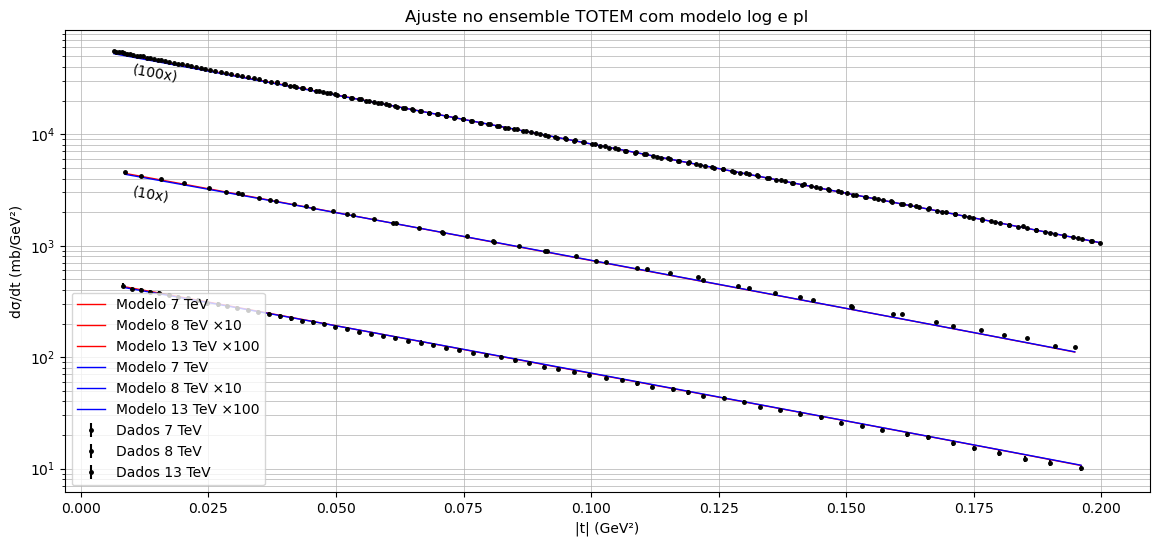

In [16]:
print("\nGerando gráficos...")

plt.figure(figsize=(14, 6))

# Adiciona os dados experimentais com barras de erro
plt.errorbar(x_7_totem, y_7_totem, yerr=yerr_7_totem, 
             fmt='o', color='black', markersize=2.5, label='Dados 7 TeV')
plt.errorbar(x_8_totem, y_8_totem*10, yerr=yerr_8_totem,
             fmt='o', color='black', markersize=2.5, label='Dados 8 TeV')
plt.errorbar(x_13_totem, y_13_totem*100, yerr=yerr_13_totem,
             fmt='o', color='black', markersize=2.5, label='Dados 13 TeV')


# Adiciona as curvas do modelo otimizado
plt.plot(x_7_totem, model_results_log[7000], 
         '-', color='red', linewidth=1, label='Modelo 7 TeV')
plt.plot(x_8_totem, model_results_log[8000]*10, 
         '-', color='red', linewidth=1, label='Modelo 8 TeV ×10')
plt.plot(x_13_totem, model_results_log[13000]*100, 
         '-', color='red', linewidth=1, label='Modelo 13 TeV ×100')


plt.plot(x_7_totem, model_results_pl[7000], 
         '-', color='blue', linewidth=1, label='Modelo 7 TeV')
plt.plot(x_8_totem, model_results_pl[8000]*10, 
         '-', color='blue', linewidth=1, label='Modelo 8 TeV ×10')
plt.plot(x_13_totem, model_results_pl[13000]*100, 
         '-', color='blue', linewidth=1, label='Modelo 13 TeV ×100')

# Configurações do gráfico
plt.title(f'Ajuste no ensemble TOTEM com modelo log e pl')
plt.text(0.01, 10**3+1500, '(10x)', rotation=350)
plt.text(0.01, 10**4+20000, '(100x)', rotation=350)
plt.xlabel('|t| (GeV²)')
plt.ylabel('dσ/dt (mb/GeV²)')
plt.yscale('log')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()

# Cria o diretório se não existir
if not os.path.exists('plots'):
    os.makedirs('plots', exist_ok=True)

# Salva a figura
# plt.savefig(f"plots/fit_optimized_totem_log_pl_test.pdf", bbox_inches='tight', dpi=1200)
plt.show()